In [40]:
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import pandas as pd
import nltk
import string
import numpy as np
import copy
from matplotlib import pyplot as  plt

In [2]:
data=pd.read_csv('train_dataset.csv')

In [3]:
comments='Comment'

In [4]:
def tokenize_sent(data):
    sentences=sent_tokenize(data)
    return sentences

def tokenize_word(data):
    words=word_tokenize(data)
    return words

In [5]:
data[comments]=data[comments].apply(tokenize_sent)

In [6]:
unigram_data=data[comments]
sentences=[]
translator = str.maketrans('', '', string.punctuation)
for data in unigram_data:
    for sent in data:
        new_sent=sent.lower()
        sentences.append(new_sent.translate(translator))

In [7]:
unigram_sent=sentences
bigram_sent=[]
trigram_sent=[]
quadgram_sent=[]

In [8]:
for sent in sentences:
    bigram_sent.append(sent)
    trigram_sent.append(sent)
    quadgram_sent.append(sent)

In [9]:
unigram_words=[]
for sent in unigram_sent:
    words=word_tokenize(sent)
    unigram_words.append(words)


In [10]:
bigram_words=unigram_words.copy()
trigram_words=unigram_words.copy()
quadgram_words = unigram_words.copy()

for sent in bigram_words:
    sent.append('</s>')
    sent.insert(0,'<s>')

In [11]:
for sent in trigram_words:
    sent.append('</s>')
    sent.append('</s>')
    sent.insert(0,'<s>')
    sent.insert(0,'<s>')

for sent in quadgram_words:
    sent.append('</s>')
    sent.append('</s>')
    sent.append('</s>')
    sent.insert(0,'<s>')
    sent.insert(0,'<s>')
    sent.insert(0,'<s>')

In [99]:
import numpy as np
start_sent='<s>'
end_sent='</s>'

class unigram_model():
    
  def __init__(self,sentences):
    self.unigram_frequencies=dict()
    self.vocabulary=set()
    self.corpus_size=0
    for sentence in sentences:
      for word in sentence:
        self.unigram_frequencies[word]=self.unigram_frequencies.get(word,0)+1
        if word!=start_sent or  word!=end_sent:  
         self.corpus_size+=1
        if word not in self.vocabulary:
         self.vocabulary.add(word)
    self.vocab_size=len(self.unigram_frequencies)-2 #Not including start and end of sentence in vocabulary

  def calculate_probability(self,word):
    if word not in self.vocabulary:
      return 0
    return float(self.unigram_frequencies[word])/float(self.corpus_size)

  def calculate_perplexity(self,word):
    prob_word=self.calculate_probability(word)
    if(prob_word==0):
      return 10**(7)
    perplexity=np.log2(float(1/prob_word))*(float(1/self.corpus_size))
    return perplexity

  def calculate_probability_smooth(self , word, k):
        
        return float(self.unigram_frequencies[word] + k)/(float(self.corpus_size) + k*float(self.vocab_size))
        
        
    
        
        


class bigram_model(unigram_model):
  def __init__(self,sentences):
    unigram_model.__init__(self,sentences)
    self.bigram_frequencies=dict()
    self.total_bigrams=0
    for sentence in sentences:
      prev_word=sentence[0]
      for word in sentence[1:]:
        self.bigram_frequencies[(prev_word,word)]=self.bigram_frequencies.get((prev_word,word),0)+1
        self.total_bigrams+=1
        prev_word=word

    self.total_bigram_words=len(self.bigram_frequencies)

  def calculate_probability(self,prev_word,word):
    a=self.bigram_frequencies.get((prev_word,word),0)
    b=self.unigram_frequencies.get(prev_word,0)

    if b==0:
      return 0
    return float(a)/float(b)

  def calculate_perplexity(self,prev_word,word):
    prob_word=self.calculate_probability(prev_word,word)
    if(prob_word==0):
      return 10**(7)
    perplexity=np.log2(float((1/prob_word)))*(float(1/self.total_bigrams))
    return perplexity

  def calculate_probability_smooth(self,prev_word,word , k):
        
    a=self.bigram_frequencies.get((prev_word,word),0)
    b=self.unigram_frequencies.get(prev_word,0)

    return (float(a) + k) /(float(b) + k*self.vocab_size)

class trigram_model(bigram_model):
    def __init__(self, sentences):
        bigram_model.__init__(self, sentences)
        self.trigram_frequencies = {}
        self.total_trigrams=0
        for sentence in sentences:
            prev_word1 = sentence[0]
            prev_word2 = sentence[1]
            for word in sentence[2:]:
              self.trigram_frequencies[(prev_word1, prev_word2, word)] = self.trigram_frequencies.get((prev_word1, prev_word2, word), 0) + 1
              prev_word1 = prev_word2
              prev_word2 = word
              self.total_trigrams+=1

        self.total_trigram_words = len(self.trigram_frequencies)
                        
    def calculate_probability(self, prev_word1, prev_word2, word):
        trigram_frequency = self.trigram_frequencies.get((prev_word1, prev_word2, word), 0)
        bigram_frequency = self.bigram_frequencies.get((prev_word2, word), 0)

        if bigram_frequency == 0:
            return 0
        return float(trigram_frequency) / float(bigram_frequency)

    def calculate_perplexity(self,prev_word1, prev_word2, word):
      prob_word=self.calculate_probability(prev_word1, prev_word2, word)
      if(prob_word==0):
        return 10**(7)
      perplexity=np.log2(float((1/prob_word)))*(float(1/self.total_trigrams))
      return perplexity

    def calculate_probability_smooth(self, prev_word1, prev_word2, word , k):
        trigram_frequency = self.trigram_frequencies.get((prev_word1, prev_word2, word), 0)
        bigram_frequency = self.bigram_frequencies.get((prev_word2, word), 0)

        return (float(trigram_frequency) + k) / (float(bigram_frequency) + k*self.vocab_size)
    
    
    


class quadgram_model(trigram_model):
    def __init__(self, sentences):
        trigram_model.__init__(self, sentences)
        self.quadgram_frequencies = {}
        self.total_quadgrams=0
        for sentence in sentences:
            prev_word1 = sentence[0]
            prev_word2 = sentence[1]
            prev_word3 = sentence[2]
            for word in sentence[3:]:
                quadgram = (prev_word1,prev_word2,prev_word3,word)
                self.quadgram_frequencies[quadgram] = self.quadgram_frequencies.get(quadgram, 0) + 1
                prev_word1 = prev_word2
                prev_word2 = prev_word3
                prev_word3 = word
                self.total_quadgrams+=1

        self.total_quadgram_words = len(self.quadgram_frequencies)


    def calculate_probability(self, prev_word1, prev_word2, prev_word3, word):
        quadgram_frequency = self.quadgram_frequencies.get( (prev_word1, prev_word2, prev_word3, word), 0)
        trigram_frequency = self.trigram_frequencies.get( (prev_word1, prev_word2, prev_word3), 0)

        if trigram_frequency == 0:
            return 0
        return float(quadgram_frequency) / float(trigram_frequency)
    
    def calculate_perplexity(self,prev_word1, prev_word2, prev_word3, word):
      prob_word=self.calculate_probability(prev_word1, prev_word2, prev_word3, word)
      if(prob_word==0):
        return 10**(7)
      perplexity=np.log2(float((1/prob_word)))*(float(1/self.total_quadgrams))
      return perplexity

    def calculate_probability_smooth(self, prev_word1, prev_word2, prev_word3, word , k):
        
        quadgram_frequency = self.quadgram_frequencies.get( (prev_word1, prev_word2, prev_word3, word), 0)
        trigram_frequency = self.trigram_frequencies.get( (prev_word1, prev_word2, prev_word3), 0)

        return (float(quadgram_frequency) + k) / (float(trigram_frequency) + k*self.vocab_size)



In [13]:
test_data=pd.read_csv('test_dataset.csv')
test_comments='Comment'

test_data[test_comments]=test_data[test_comments].apply(tokenize_sent)
test_unigram_data=test_data[test_comments]
test_sentences=[]
for data in test_unigram_data:
    for sent in data:
        new_sent=sent.lower()
        test_sentences.append(new_sent.translate(translator))

test_unigram_sent=test_sentences
test_unigram_words=[]
for sent in test_unigram_sent:
    words=word_tokenize(sent)
    test_unigram_words.append(words)

In [21]:
UNIGRAM_MODEL=unigram_model(unigram_words)

count=0
total_perplex = 0
for data in test_unigram_words:

    count+=1
    n = len(data)
    if(n == 0): continue
    unigram_perplex=0
    for word in data:
        unigram_perplex += np.log2(UNIGRAM_MODEL.calculate_probability(word))
    
    unigram_perplex *= (-1/n)
    final_perplex = 2 ** unigram_perplex
    total_perplex += final_perplex
        
        
avg_perplex = total_perplex/count

/tmp/ipykernel_20023/3860985320.py:12: RuntimeWarning: divide by zero encountered in log2
  unigram_perplex += np.log2(UNIGRAM_MODEL.calculate_probability(word))


In [22]:
avg_perplex

inf

In [23]:
BIGRAM_MODEL=bigram_model(bigram_words)
total_perplex=0
count=0

for data in test_unigram_words:
    count+= 1
    bigram_perplex = 0
    n = len(data)
    if(n < 2): continue
    
    for i in range(len(data)-1):
        bigram_perplex+=np.log2(BIGRAM_MODEL.calculate_probability(data[i],data[i+1]))
        
    bigram_perplex *= (-1/n)
    final_perplex = 2 ** bigram_perplex
    total_perplex += final_perplex
        
        
Avg_perplex=total_perplex/count
Avg_perplex

/tmp/ipykernel_20023/2406518176.py:12: RuntimeWarning: divide by zero encountered in log2
  bigram_perplex+=np.log2(BIGRAM_MODEL.calculate_probability(data[i],data[i+1]))


inf

In [24]:
TRIGRAM_MODEL=trigram_model(trigram_words)
total_perplex=0
count=0

for data in test_unigram_words:
    count+= 1
    trigram_perplex = 0
    n = len(data)
    if(n < 3): continue
    
    for i in range(len(data)-2):
        trigram_perplex+=np.log2(TRIGRAM_MODEL.calculate_probability(data[i],data[i+1], data[i+2]))
        
    trigram_perplex *= (-1/n)
    final_perplex = 2 ** trigram_perplex
    total_perplex += final_perplex
        
        
Avg_perplex=total_perplex/count
Avg_perplex

/tmp/ipykernel_20023/3152368260.py:12: RuntimeWarning: divide by zero encountered in log2
  trigram_perplex+=np.log2(TRIGRAM_MODEL.calculate_probability(data[i],data[i+1], data[i+2]))


inf

In [25]:
QUADGRAM_MODEL=quadgram_model(quadgram_words)
total_perplex=0
count=0

for data in test_unigram_words:
    count+= 1
    quadgram_perplex = 0
    n = len(data)
    if(n < 4): continue
    
    for i in range(len(data)-3):
        quadgram_perplex+=np.log2(QUADGRAM_MODEL.calculate_probability(data[i],data[i+1], data[i+2] , data[i+3]))
        
    quadgram_perplex *= (-1/n)
    final_perplex = 2 ** quadgram_perplex
    total_perplex += final_perplex
        
        
Avg_perplex=total_perplex/count
Avg_perplex

/tmp/ipykernel_20023/3051838552.py:12: RuntimeWarning: divide by zero encountered in log2
  quadgram_perplex+=np.log2(QUADGRAM_MODEL.calculate_probability(data[i],data[i+1], data[i+2] , data[i+3]))


inf

In [31]:
?np.linspace

In [63]:
x = np.linspace(31 , 32 , 10 , endpoint = True)   
y = []
UNIGRAM_MODEL=unigram_model(unigram_words)

for data in test_unigram_sent:
    for word in data:
        if word not in UNIGRAM_MODEL.vocabulary:
            UNIGRAM_MODEL.vocabulary.add(word)
            UNIGRAM_MODEL.vocab_size += 1
            UNIGRAM_MODEL.unigram_frequencies[word] = 0

for k in x:
    
    count=0
    total_perplex = 0
    for data in test_unigram_sent:

        count+=1
        n = len(data)
        if(n == 0): continue
        unigram_perplex=0
        for word in data:
            unigram_perplex += np.log2(UNIGRAM_MODEL.calculate_probability_smooth(word , k) )

        unigram_perplex *= (-1/n)
        final_perplex = 2 ** unigram_perplex
        total_perplex += final_perplex

    avg_perplex = total_perplex/count
    print(avg_perplex)
    y.append(avg_perplex)

19866.648109104008
19866.60275617038
19866.594433690287
19866.62277164545
19866.687404664663
19866.78797195179
19866.924117208877
19867.09548857111
19867.30173853142
19867.542523878234


In [64]:
x[np.argmin(y)]

31.22222222222222

Text(0, 0.5, 'Average Perplexity')

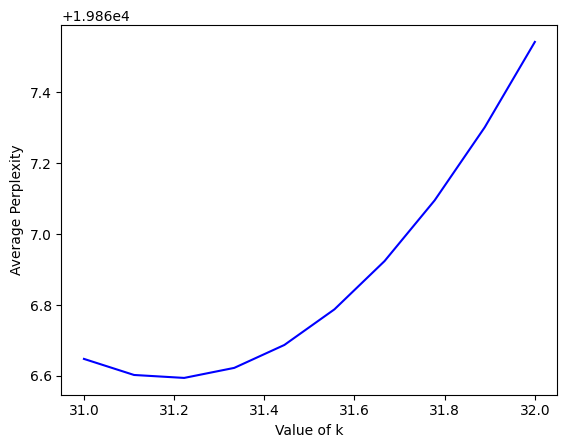

In [67]:
plt.plot(x , y , color = 'blue')
plt.xlabel('Value of k')
plt.ylabel('Average Perplexity')

In [78]:
x = np.linspace(0.01 , 0.015 , 10 , endpoint = True)   
y = []
BIGRAM_MODEL=bigram_model(bigram_words)

for data in test_unigram_sent:
    n = len(data)
    for word in data:
        if word not in BIGRAM_MODEL.vocabulary:
            BIGRAM_MODEL.vocabulary.add(word)
            BIGRAM_MODEL.vocab_size += 1
    
    for i in range(n-1):
        
        if(data[i], data[i+1]) not in BIGRAM_MODEL.bigram_frequencies:
            BIGRAM_MODEL.bigram_frequencies[(data[i], data[i+1])] = 0
            
for k in x:
    
    total_perplex=0
    count=0

    for data in test_unigram_words:
        count+= 1
        bigram_perplex = 0
        n = len(data)
        if(n < 2): continue

        for i in range(len(data)-1):
            
            bigram_perplex+=np.log2(BIGRAM_MODEL.calculate_probability_smooth(data[i],data[i+1] , k))

        bigram_perplex *= (-1/n)
        final_perplex = 2 ** bigram_perplex
        total_perplex += final_perplex


    Avg_perplex=total_perplex/count
    y.append(Avg_perplex)
    print(Avg_perplex)

1023.6532436678829
1023.3876940997279
1023.408443644035
1023.6748642395859
1024.153309552863
1024.8156828962776
1025.6383446729792
1026.6012686735967
1027.687383298317
1028.8820519420929


In [79]:
x[np.argmin(y)]

0.010555555555555556

Text(0, 0.5, 'Average Perplexity')

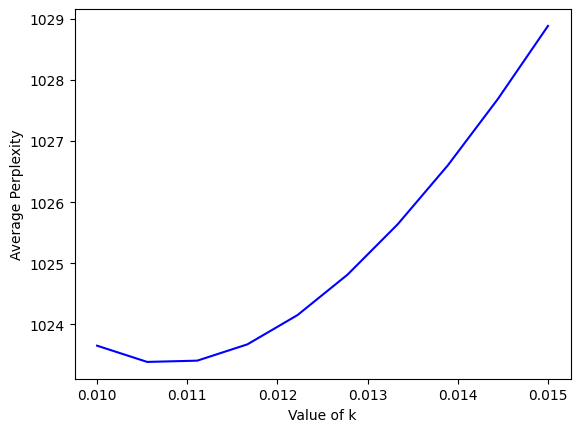

In [80]:
plt.plot(x , y , color = 'blue')
plt.xlabel('Value of k')
plt.ylabel('Average Perplexity')

In [ ]:
TRIGRAM_MODEL=trigram_model(trigram_words)

y = []
for data in test_unigram_sent:
    n = len(data)
    for word in data:
        if word not in TRIGRAM_MODEL.vocabulary:
            TRIGRAM_MODEL.vocabulary.add(word)
            TRIGRAM_MODEL.vocab_size += 1
    
    for i in range(n-2):
        if(data[i], data[i+1], data[i+2]) not in TRIGRAM_MODEL.trigram_frequencies:
            TRIGRAM_MODEL.trigram_frequencies[(data[i], data[i+1] , data[i+2])] = 0

In [91]:
x = np.linspace(0.001 , 0.002 , 10 , endpoint = True)  
y = []
for k in x:
    
    total_perplex=0
    count=0

    for data in test_unigram_words:
        count+= 1
        trigram_perplex = 0
        n = len(data)
        if(n < 3): continue

        for i in range(len(data)-2):
            trigram_perplex+=np.log2(TRIGRAM_MODEL.calculate_probability_smooth(data[i],data[i+1], data[i+2] ,k))

        trigram_perplex *= (-1/n)
        final_perplex = 2 ** trigram_perplex
        total_perplex += final_perplex


    Avg_perplex=total_perplex/count
    print(Avg_perplex)
    y.append(Avg_perplex)

2272.24823663145
2268.611825452615
2266.834520339749
2266.4514763245156
2267.134247497119
2268.6444439952847
2270.805099776619
2273.482310784789
2276.573080691662
2279.9970534792924


In [92]:
x[np.argmin(y)]

0.0013333333333333335

Text(0, 0.5, 'Average Perplexity')

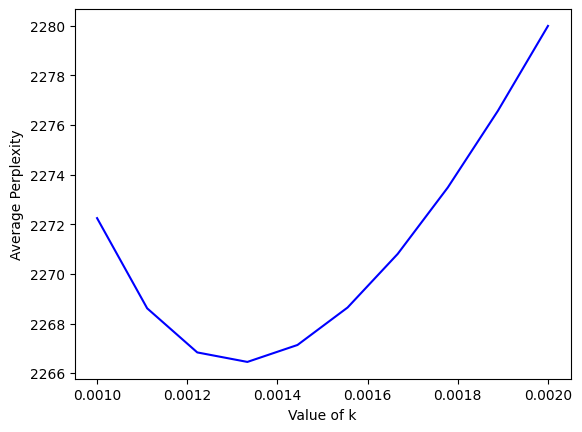

In [93]:
plt.plot(x , y , color = 'blue')
plt.xlabel('Value of k')
plt.ylabel('Average Perplexity')

In [101]:
QUADGRAM_MODEL= quadgram_model(quadgram_words)

y = []
for data in test_unigram_sent:
    n = len(data)
    for word in data:
        if word not in QUADGRAM_MODEL.vocabulary:
            QUADGRAM_MODEL.vocabulary.add(word)
            QUADGRAM_MODEL.vocab_size += 1
    
    for i in range(n-3):
        if(data[i], data[i+1], data[i+2] , data[i+3]) not in QUADGRAM_MODEL.quadgram_frequencies:
            QUADGRAM_MODEL.quadgram_frequencies[(data[i], data[i+1] , data[i+2] , data[i+3])] = 0

In [102]:
x = np.linspace(0.001 , 0.002 , 10 , endpoint = True)  
y = []
for k in x:
    
    total_perplex=0
    count=0

    for data in test_unigram_words:
        count+= 1
        quadgram_perplex = 0
        n = len(data)
        if(n < 4): continue

        for i in range(len(data)-3):
            quadgram_perplex+=np.log2(QUADGRAM_MODEL.calculate_probability_smooth(data[i],data[i+1], data[i+2],data[i+3] ,k))

        quadgram_perplex *= (-1/n)
        final_perplex = 2 ** quadgram_perplex
        total_perplex += final_perplex


    Avg_perplex=total_perplex/count
    print(Avg_perplex)
    y.append(Avg_perplex)

4037.3315272148225
4046.4841468247864
4055.719818620009
4064.9267558153324
4074.037048127345
4083.0096542077395
4091.8204083723826
4100.4559443946255
4108.909895379689
4117.180461205602


In [17]:
class N_Gram(unigram_model):
    def __init__(self,sentences,n):
        if(n==1):
            self.model=unigram_model(sentences)
        if(n==2):
            self.model=bigram_model(sentences)
        if(n==3):
            self.model=trigram_model(sentences)
        if(n==4):
            self.model=quadgram_model(sentences)

In [18]:
test_uni_gram_model=N_Gram(unigram_words,1)
test_bi_gram_model=N_Gram(bigram_words,2)
test_tri_gram_model=N_Gram(trigram_words,3)
test_quad_gram_model=N_Gram(quadgram_words,4)

In [19]:
print(test_uni_gram_model.model.calculate_probability('the'))
print(test_bi_gram_model.model.calculate_probability('is','the'))
print(test_tri_gram_model.model.calculate_probability('seems','to','me'))
print(test_quad_gram_model.model.calculate_probability('seems','to','me','that'))

0.021748511511320123
0.0656356214730611
0.03412073490813648
0.46153846153846156


In [36]:
test_quad_gram_model= N_Gram(quadgram_words,4)